# Import libs

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import os
import scipy.io as sio
import numpy as np
from models import *
from utils.sr_utils import *
import pywt
import torch
import torch.optim

from skimage.metrics import peak_signal_noise_ratio as psnr
from utils.denoising_utils import *
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
from pytorch_wavelets import DWT, IDWT
xfm = DWT(mode='symmetric', wave='haar').cuda()  # Accepts all wave types available to PyWavelets
ifm = IDWT(mode='symmetric', wave='haar').cuda()

In [2]:
def cub2mat(X):
    return(X.reshape(X.shape[0], X.shape[1]*X.shape[2]))
def mat2cub(X,r):
    return(X.reshape(X.shape[0],r, int(X.shape[1]/r)))

# Load image

In [3]:
file_name  = 'data/denoising/PU.mat'
sigma = 0.1
mat = sio.loadmat(file_name)
img_np = mat["img"]
img_np = img_np.transpose(2,0,1)
img_var = torch.from_numpy(img_np).type(dtype)
img_noisy_np = get_noisy_image(img_np, sigma)
img_noisy_var = torch.from_numpy(img_noisy_np).type(dtype)
[d,r,c]=img_var.shape

In [4]:
#SVD for noisy image
X = img_noisy_var.reshape(img_var.shape[0], img_var.shape[1]*img_var.shape[2])
ref_mat=cub2mat(img_var)
u,s,vt=torch.svd(X)
eig=4
s1=s[:eig]
u1=u[:,:eig]
vt1=vt[:,:eig]
v1=torch.transpose(vt1,1,0)
u1t=torch.transpose(u1,1,0)
X1=torch.matmul(u1t,X) #eigen image matrix
X1_img = mat2cub(X1,r) #eigen image -->noisy input
X1_var = X1_img[None,:]

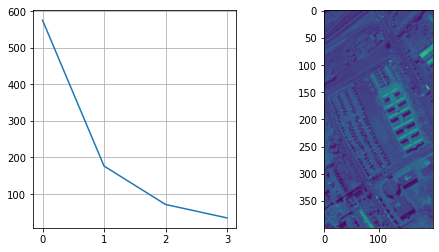

In [5]:
f, [ax1, ax2] = plt.subplots(1, 2, sharey=False, figsize=(8,4))
ax1.plot(s1.cpu())
ax1.grid()
ax2.imshow(X1_img.cpu()[0,:,:]) #first eigen
plt.show()

In [6]:
# Wavelet transform
(cA, ch)=xfm(X1_var)

### Visualize

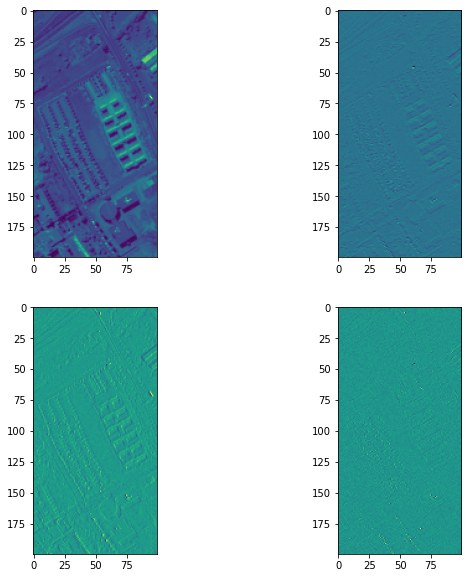

In [7]:
f, [[ax1, ax2],[ax3,ax4]] = plt.subplots(2, 2, sharey=False, figsize=(10,10))
ax1.imshow(cA[0,0,:,:].cpu())

ax2.imshow(ch[0][0,0,0,:,:].cpu())
ax3.imshow(ch[0][0,0,1,:,:].cpu())
ax4.imshow(ch[0][0,0,2,:,:].cpu())
plt.show()

# Setup

In [8]:
pad = 'reflection'
show_every = 100
num_iter = 3001
input_depth = X1.shape[0]  
net = skip(input_depth, X1.shape[0],  
       num_channels_down = [128]*5,
       num_channels_up =   [128]*5,
       num_channels_skip =    [4]*5,  
       filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
       upsample_mode='bilinear',  downsample_mode='stride',
       need1x1_up=False,
       need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

net_input = X1_var
# Optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [9]:
psnr_total=[]
loss=[]
psnr_init=0.
img_best=[]
import time
t0=time.time()
for i in range(num_iter):
    optimizer.zero_grad()
    X1_out = net(net_input) #eigen image out
    (ap,det)=xfm(X1_out)
    total_loss = torch.sum((X1_out-X1_var)**2) + 0.25*torch.sum(torch.abs(det[0]))
    total_loss.backward()
    optimizer.step()
    X1_out_mat = cub2mat(X1_out.detach().squeeze(dim=0)) #191x200x200 (h,v,d)
    X_out = mat2cub(torch.matmul(u1,X1_out_mat),r)
    out_np = X_out.cpu().numpy()

    psnr_gt    = psnr(img_np.astype(np.float32),out_np)
    psnr_total.append(psnr_gt)
    loss.append(total_loss.detach().cpu().numpy())
    if psnr_gt>psnr_init:
        img_best=out_np
        psnr_init=psnr_gt
    print ('Iteration %05d    Loss %f  PSRN_gt: %f' % (i, total_loss.item(), psnr_gt), '\r', end='')
#     if i % show_every == 0:
#         f, [ax1, ax2, ax3] = plt.subplots(1, 3, sharey=False, figsize=(10,10))
#         ax1.imshow(out_np.transpose(1,2,0)[:,:,[56,26,16]])
#         ax2.imshow(img_noisy_np.transpose(1,2,0)[:,:,[56,26,16]])
#         ax3.imshow(img_np.transpose(1,2,0)[:,:,[56,26,16]])
#         plt.show()
    

/home/han/anaconda3/envs/wavelet/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


35.701200584658565


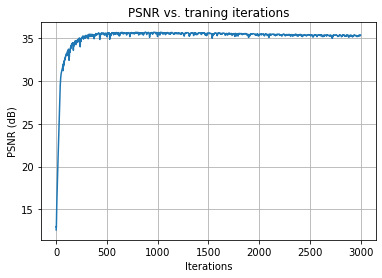

In [10]:
print(psnr(img_np.astype(np.float32),img_best))
plt.plot(psnr_total)
plt.title('PSNR vs. traning iterations')
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')
plt.grid()
plt.show()